The Following paper has been implemented in this notebook: https://arxiv.org/pdf/2010.11929.pdf



In [36]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1
import torchvision

In [37]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading Data


## Training data

In [38]:
train = '/content/drive/MyDrive/Project/downloads'
folders = os.listdir(train)
folders.sort()
count = -1
print(folders)
images = []
label = []
for folder in folders:
  print(folder)
  count += 1
  path = os.path.join(train,folder)
  for file in os.listdir(path):
    file_path = os.path.join(path,file)
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    images.append(img)
    label.append(count)

['cat', 'crocodile', 'dog', 'elephant', 'giraffe', 'lion']
cat
crocodile
dog
elephant
giraffe
lion


In [39]:
images = np.array(images)
labels = np.array(label)
print("Shape of images: ", images.shape)
print("Shape of Labels: ", labels.shape)

Shape of images:  (914, 256, 256, 3)
Shape of Labels:  (914,)


## Test data

In [40]:
test_folder = '/content/drive/MyDrive/Project/test_data'

folders = os.listdir(test_folder)
folders.sort()
count = -1
print(folders)
test = []
test_label = []
for folder in folders:
  print(folder)
  count += 1
  path = os.path.join(test_folder,folder)
  for file in os.listdir(path):
    file_path = os.path.join(path,file)
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    test.append(img)
    test_label.append(count)

['cat', 'crocodile', 'dog', 'elephant', 'giraffe', 'lion']
cat
crocodile
dog
elephant
giraffe
lion


In [41]:
test = np.array(test)
test_labels = np.array(test_label)

print("Shape of images: ", test.shape)
print("Shape of Labels: ", test_labels.shape)

Shape of images:  (90, 256, 256, 3)
Shape of Labels:  (90,)


## Visualizing some images:

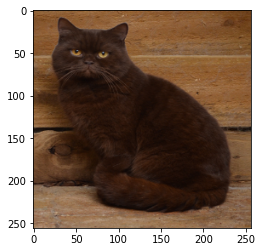

Its label:  0
----------------------------------------


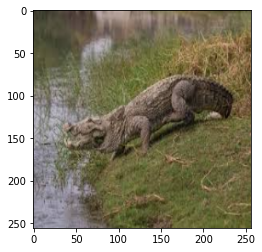

Its label:  1
----------------------------------------


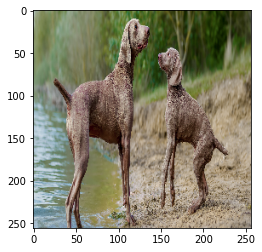

Its label:  2
----------------------------------------


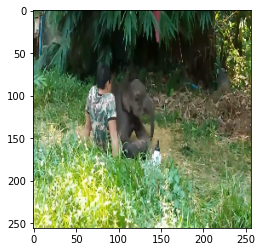

Its label:  3
----------------------------------------


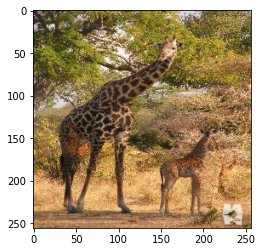

Its label:  4
----------------------------------------


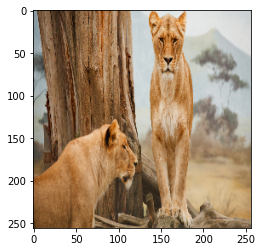

Its label:  5
----------------------------------------


In [42]:
plt.imshow(images[10])
plt.show()
print("Its label: ", labels[10])
print("----------------------------------------")
plt.imshow(images[190])
plt.show()
print("Its label: ", labels[190])
print("----------------------------------------")
plt.imshow(images[266])
plt.show()
print("Its label: ", labels[266])
print("----------------------------------------")
plt.imshow(images[452])
plt.show()
print("Its label: ", labels[452])
print("----------------------------------------")
plt.imshow(images[610])
plt.show()
print("Its label: ", labels[610])
print("----------------------------------------")
plt.imshow(images[800])
plt.show()
print("Its label: ", labels[800])
print("----------------------------------------")

In [43]:
num_slices = 16

img = []

for idx in range(images.shape[0]): 
  temp = []
  for i in range(0,images.shape[1], int(images.shape[1]/num_slices)):
    for j in range(0,images.shape[1], int(images.shape[1]/num_slices)):
      temp.append(images[idx, i : (i + int(images.shape[1]/num_slices)), j : (j + int(images.shape[1]/num_slices))   ,:])
  

      """print(images[idx, i : (i + int(images.shape[1]/num_slices)), j : (j + int(images.shape[1]/num_slices)) ,:].shape)
      print(img[idx, count, :, :, :].shape)
      plt.imshow(images[idx])
      plt.show()
      plt.imshow(images[idx, i : (i + int(images.shape[1]/num_slices)), j : (j + int(images.shape[1]/num_slices)) ,:])
      plt.show()"""

  img.append(temp)


In [44]:
num_slices = 16

test_img = []

for idx in range(test.shape[0]): 
  temp = []
  for i in range(0,test.shape[1], int(test.shape[1]/num_slices)):
    for j in range(0,test.shape[1], int(test.shape[1]/num_slices)):
      temp.append(test[idx, i : (i + int(test.shape[1]/num_slices)), j : (j + int(test.shape[1]/num_slices))   ,:])

  test_img.append(temp)

In [45]:
img = np.array(img)
test_img = np.array(test_img)

In [46]:
print("Shape of the sliced array for use in Vision Transformer for training: ", img.shape)
print("Shape of the sliced array for use in Vision Transformer for test data: ", test_img.shape)

Shape of the sliced array for use in Vision Transformer for training:  (914, 256, 16, 16, 3)
Shape of the sliced array for use in Vision Transformer for test data:  (90, 256, 16, 16, 3)


## Visualizing one smaple

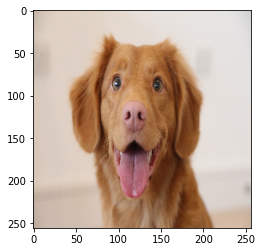

In [47]:
plt.imshow(images[400])
plt.show()

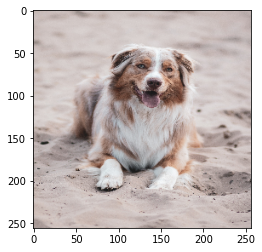

In [49]:
#From test data
plt.imshow(test[40])
plt.show()

## Example figure if we split the figure in 16x16 patches. In our implementation we will split the figure into 16x16.

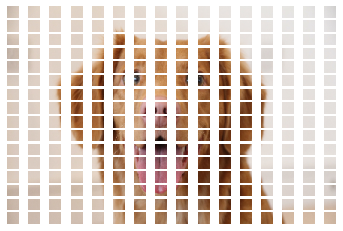

In [48]:
for i in range(img.shape[1]):
  plt.subplot(num_slices,num_slices,i+1)
  plt.axis('off')
  plt.imshow(img[400,i])

plt.show()

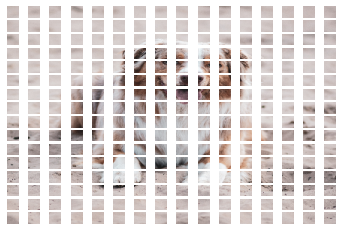

In [50]:
for i in range(test_img.shape[1]):
  plt.subplot(num_slices,num_slices,i+1)
  plt.axis('off')
  plt.imshow(test_img[40,i])

plt.show()

In [14]:
#Reshaping to use it in transformers:
img = img.reshape(img.shape[0], img.shape[1], -1)
print("Shape of img after reshaping: ", img.shape)

Shape of img after reshaping:  (914, 256, 768)


In [60]:
#Reshaping test data to use it in transformers:
test_img = test_img.reshape(test_img.shape[0], test_img.shape[1], -1)
print("Shape of test_img after reshaping: ", test_img.shape)

Shape of test_img after reshaping:  (90, 256, 768)


In [16]:
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'


cuda GPU is available


In [17]:
img =  torch.tensor(img, dtype = torch.float32, device= DEVICE)
labels = torch.tensor(labels, dtype = torch.float32, device= DEVICE).long()
#test
test_img =  torch.tensor(test_img, dtype = torch.float32, device= DEVICE)
test_labels = torch.tensor(test_labels, dtype = torch.float32, device= DEVICE).long()

#Multi-Head Attention

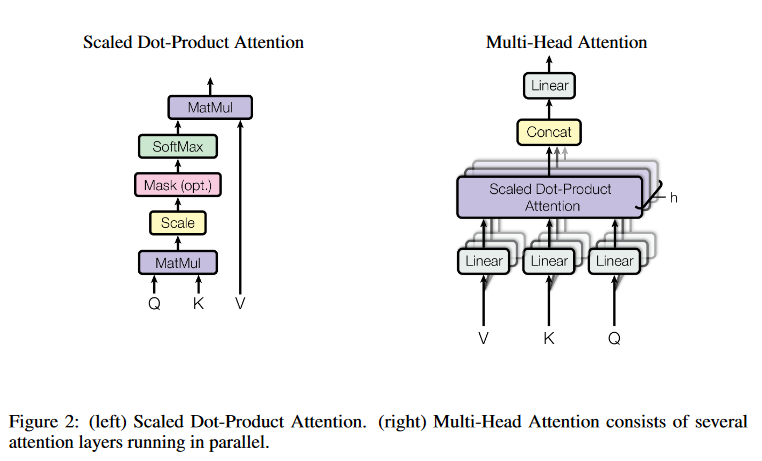

In [18]:
class SelfAttention(nn.Module):   #multi-head attention
  def __init__(self, num_heads, embedding_size, heads_dim ):
    super(SelfAttention, self).__init__()
    self.heads = num_heads  
    self.embed = embedding_size  #768 = 16*16*3
    self.head_dim = heads_dim    #heads_dim or (embedding_size//num_heads) 

    self.values_fc = nn.Linear(self.head_dim, self.head_dim)
    self.keys_fc = nn.Linear(self.head_dim, self.head_dim)
    self.queries_fc = nn.Linear(self.head_dim, self.head_dim)

    self.final_out = nn.Linear(self.embed, self.embed)
    self.dropout  = nn.Dropout(p=0.2)

  def forward(self, key, value, query):
    #reshaping
    key = key.reshape(key.shape[0], key.shape[1], self.heads, self.head_dim)  #(N,7,8,32)
    value = value.reshape(value.shape[0], value.shape[1], self.heads, self.head_dim)
    query = query.reshape(query.shape[0], query.shape[1], self.heads, self.head_dim)

    value = self.values_fc(self.dropout(value))
    key = self.keys_fc(self.dropout(key))
    query = self.queries_fc(self.dropout(query))

    #MatMul between query and key
   
    matmul = torch.einsum("nshd,nkhd->nhsk", [query, key])  
    
    #softmax
    attn = torch.softmax(matmul/(self.embed**(0.5)), dim = 3) 
    

    #MatMul between attn and value
    matmul_final = torch.einsum("nhql,nlhd->nqhd", [attn, value])  
    
    #scaled dot product attention part is done 
    #concatention
    out = matmul_final.reshape(value.shape[0], value.shape[1], -1) 

    return out


#Encoder Block

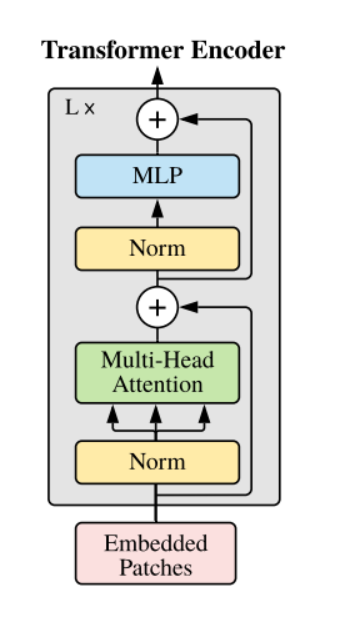

In [19]:
class transformer_encoder_block(nn.Module):
  def __init__(self, num_heads, embedding_size, heads_dim, forward_expansion ):
    super(transformer_encoder_block, self).__init__()
    self.attention = SelfAttention(num_heads, embedding_size, heads_dim)  #embedding size = 768

    
    self.layer_norm2 = nn.LayerNorm(embedding_size)
    self.dropout  = nn.Dropout(p=0.2)

    #feed forward netrwork
    self.feed_forward = nn.Sequential(
        nn.Linear(embedding_size, forward_expansion*embedding_size ),
        nn.ReLU(),
        nn.Linear(forward_expansion*embedding_size, embedding_size )
    )

  def forward(self, key, value, query):
    attn = self.attention(key, value, query)

    #skip connection + layernorm
    out = attn + value

    #feed forward + skip connection + layer norm
    outff = self.feed_forward(self.dropout(self.layer_norm2(out)))
    out = out + outff

    return out


#Complete Encoder (with multiple encoder blocks)

In [20]:
class encoder(nn.Module):
  def __init__(self, num_heads, embedding_size, heads_dim, forward_expansion, DEVICE, num_layer):
    super(encoder, self).__init__()
    self.num_heads = num_heads
    self.embedding_size = embedding_size
    self.heads_dim = heads_dim
    self.forward_expansion = forward_expansion
    self.DEVICE = DEVICE  

    #word embeddings and position embeddings:
    self.position_embeddings = nn.Embedding(257, embedding_size )  

    self.network = nn.ModuleList( [ transformer_encoder_block(num_heads, embedding_size, heads_dim, forward_expansion) for i in range(num_layer)])

    self.layer_norm1 = nn.LayerNorm(embedding_size)

  def forward(self, input):
    word = torch.arange(0,input.shape[1]).expand(input.shape[0],input.shape[1]).to(self.DEVICE)

    out = input + self.position_embeddings(word) 
    
    for layer in self.network:
      out = self.layer_norm1(out)
      out = layer(out, out, out)
    

    return out

# Vision Transformer

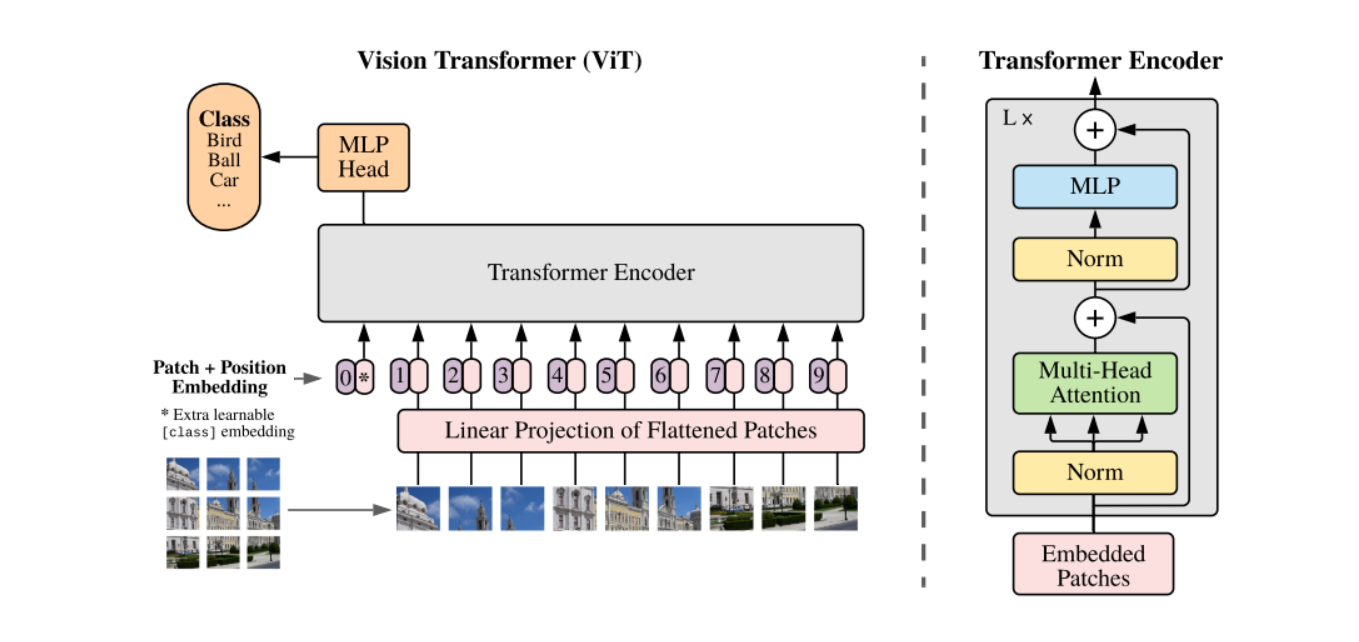

In [21]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 456 kB/s 


In [22]:
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

class VisionTransformer(nn.Module):
  def __init__(self,num_heads, embedding_size, heads_dim, forward_expansion, 
               DEVICE, num_classes , num_layer):
    super(VisionTransformer, self).__init__()
    self.DEVICE = DEVICE
    self.encoder = encoder( num_heads, embedding_size, heads_dim, forward_expansion, DEVICE, num_layer)
    
    
    self.embedding_size = embedding_size


    self.output = nn.Linear(embedding_size, num_classes)

    self.cls_token = nn.Parameter(torch.randn(1,1, embedding_size))
    
  def forward(self, input):
    #input = (N,256,768)


    cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=input.shape[0])

    #print("cls tokens shape ", cls_tokens.shape)
    input = torch.cat((input, cls_tokens), 1)

    #print("Shape after catenation: ", input.shape)

    out = self.encoder(input)

    out = out[:,256,:]

    out = self.output(out)

    return out


In [23]:
transformer_model = VisionTransformer(num_heads = 8, embedding_size = 768, heads_dim = 96, forward_expansion = 4, 
               DEVICE = DEVICE, num_classes = 6 , num_layer = 4).to(DEVICE)


In [24]:
inp = torch.ones((3,256, 768), dtype = torch.int32, device= DEVICE)

#defining some important stuffs required for training:

In [25]:
from torch.utils.data import Dataset, DataLoader


class CustomImageDataset(Dataset):   
    def __init__(self, input, output):
        self.images = input
        self.masks = output

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        x_batch = self.images[idx]
        y_batch = self.masks[idx]
        return x_batch, y_batch

In [26]:
data = CustomImageDataset(img, labels)

In [27]:
batchsize = 40
dataloader = DataLoader(dataset= data, batch_size= batchsize, shuffle= True)

In [28]:
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.0001)        #update the weights of the model 
loss_type = torch.nn.CrossEntropyLoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 100, gamma = 0.5)  #Learning rate schedular

#Training the network

In [29]:
#Model Training
loss_graph = []
num_epochs = 150   

path_folder = '/content/drive/MyDrive/DL/saved_weights/vision_transformer'
for j in range(num_epochs):

  transformer_model.train()
  for i, (x_batch, y_batch) in enumerate(dataloader):
    #print("x batch: ", x_batch.shape)
    #print("y_batch: ", y_batch.shape)

    optimizer.zero_grad()
    y_pred = transformer_model(x_batch)
    
    y_pred = y_pred.reshape(-1,6) 
    y_batch = y_batch.reshape(-1)
    y_batch = y_batch.type(torch.LongTensor).to(DEVICE)
  
    loss = loss_type(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    loss_graph.append(loss.cpu().item())
    #print("Loss is: ", loss.item())


  if (j)%10 == 0:
    PATH = os.path.join(path_folder, 'model_transformer' + str(j+1)+ '.pth')
    torch.save(transformer_model.state_dict(), PATH)
    print("Epoch: ", j+1, ", loss is: ", loss.cpu().item())
    transformer_model.eval()
    out_test = torch.argmax(transformer_model(test_img), axis = 1).reshape(-1)
    accuracy = torch.sum(out_test == test_labels)/test_img.shape[0]
    print("Accuracy on test data: ", accuracy.item()*100)
    print("-----------------------------------------------------------")
  

Epoch:  1 , loss is:  1.7466459274291992
Accuracy on test data:  22.22222238779068
-----------------------------------------------------------
Epoch:  11 , loss is:  1.5182349681854248
Accuracy on test data:  28.888890147209167
-----------------------------------------------------------
Epoch:  21 , loss is:  1.0929107666015625
Accuracy on test data:  46.666666865348816
-----------------------------------------------------------
Epoch:  31 , loss is:  0.5389070510864258
Accuracy on test data:  47.777777910232544
-----------------------------------------------------------
Epoch:  41 , loss is:  0.2253427654504776
Accuracy on test data:  50.0
-----------------------------------------------------------
Epoch:  51 , loss is:  0.032248638570308685
Accuracy on test data:  53.33333611488342
-----------------------------------------------------------
Epoch:  61 , loss is:  0.004702384117990732
Accuracy on test data:  51.11111402511597
-----------------------------------------------------------

In [30]:
## Last Accuracy
print("Final loss: ", loss.item())
transformer_model.eval()
out_test = torch.argmax(transformer_model(test_img), axis = 1).reshape(-1)
accuracy = torch.sum(out_test == test_labels)/test_img.shape[0]
print("Accuracy on test data: ", accuracy.item()*100)

Final loss:  0.01417938806116581
Accuracy on test data:  51.11111402511597


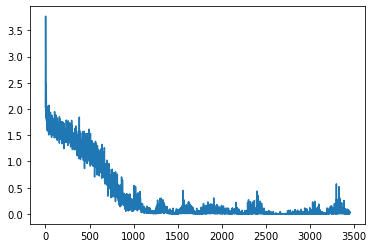

In [31]:
#Loss curve:
plt.plot(loss_graph)
plt.show()

## Loading the best model:

In [68]:
PATH = os.path.join('/content/drive/MyDrive/DL/saved_weights/vision_transformer', 'model_transformer141.pth')
transformer_model.load_state_dict(torch.load(PATH))
transformer_model.eval()

VisionTransformer(
  (encoder): encoder(
    (position_embeddings): Embedding(257, 768)
    (network): ModuleList(
      (0): transformer_encoder_block(
        (attention): SelfAttention(
          (values_fc): Linear(in_features=96, out_features=96, bias=True)
          (keys_fc): Linear(in_features=96, out_features=96, bias=True)
          (queries_fc): Linear(in_features=96, out_features=96, bias=True)
          (final_out): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (feed_forward): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): ReLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (1): transformer_encoder_block(
        (attention): SelfAttention(
          (values_fc): Linear(in_featur

# Let's see some predictions:

In [69]:
out  = torch.argmax(transformer_model(test_img), axis = 1).reshape(-1)

In [70]:
test_img.shape

torch.Size([90, 256, 768])

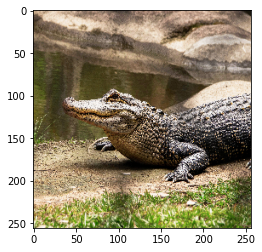

In [71]:
plt.imshow(test[15])
plt.show()

In [72]:
print("Label predicted for the above image: ", out[15].item())

Label predicted for the above image:  1


## Confusion Matrix:

In [73]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [74]:
import seaborn as sns

In [75]:
categories = [0,1,2,3,4,5]

In [76]:
cf_matrix = confusion_matrix(test_labels.cpu(), out.cpu())
df_cm = pd.DataFrame(cf_matrix/15 , index = [i for i in categories],
                      columns = [i for i in categories])

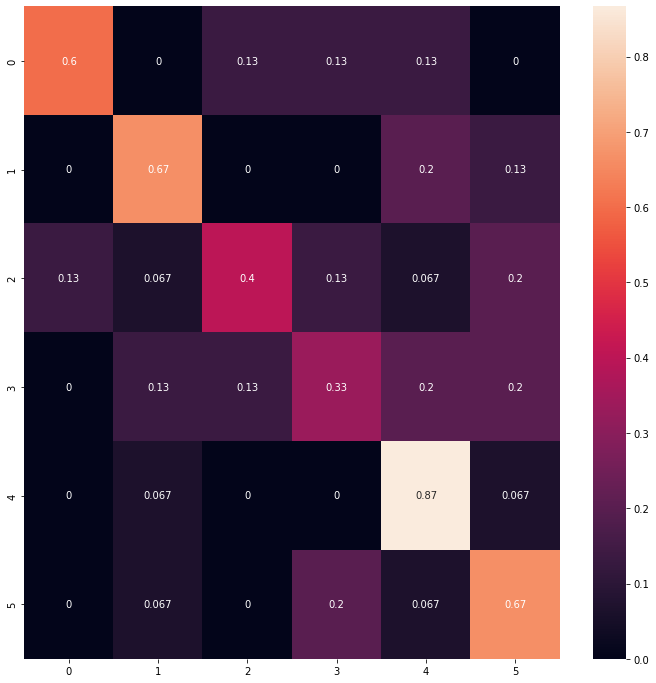

In [77]:
plt.figure(figsize = (12,12))

sns.heatmap(df_cm, annot=True)

plt.show()